引入

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from einops import rearrange
from scipy.signal import stft, get_window, windows,butter, filtfilt, detrend
from scipy.signal.windows import hamming
import os

In [17]:
class FMCWProcess:
    def __init__(self):
        self.Br = 100e6        # 调制带宽
        # PRT = 1.024e-3    # 调制周期
        self.PRT = 0.3e-3      # 调制周期 (default)
        self.Fs = 500e3        # 采样频率
        self.minR = 2          # 起始距离
        self.maxR = 15         # 终止距离
        self.C = 3e8           # 光速
        self.PRF = 1 / self.PRT     # 重复频率
        self.target_range = 9  # 目标距离 (米)

    def moving_average(self, dc_removed, window_size=5):
        n_range, n_pulse = dc_removed.shape
        trend_removed = np.zeros_like(dc_removed)
        
        for i in range(n_range):
            signal = dc_removed[i, :]
            trend = np.zeros_like(signal)
            
            for j in range(n_pulse):
                left = max(0, j - window_size)
                right = min(n_pulse, j + window_size + 1)
                neighbors = np.concatenate([signal[left:j], signal[j+1:right]])
                trend[j] = np.mean(neighbors) if len(neighbors) > 0 else 0
            
            trend_removed[i, :] = signal - trend
        
        return trend_removed
    
    def read_data(self, file_path):
        mat_data = scipy.io.loadmat(file_path)
        
        basename = os.path.basename(file_path)
        self.PRT = float(basename.split('-')[2]) * 1e-3
        self.PRF = 1 / self.PRT
        self.Br = float(basename.split('-')[3]) * 1e6
        self.target_range = float(basename.split('-')[4])
        
        self.echo = mat_data['echoes']['channelA'][0][0]   # get I/Q echo signal
        self.echo = self.echo / np.std(self.echo)

        return self.echo

    def pre_processing(self, echo=None, use_filter=True):
        if echo is None:
            echo = self.echo

        self.Nr, self.Na = echo.shape
        echo_positive = echo[:self.Nr//2, :]   # de-negative
        echo_RDC = echo_positive - np.mean(echo_positive, axis=0, keepdims=True)  # de-DC
        if use_filter:
            echo_smooth = self.moving_average(echo_RDC, window_size=5)  # debounce
        else:
            echo_smooth = echo_RDC

        return echo_smooth
    
    def range_FFT(self, echo):
        # time axis
        time = self.Na * self.PRT
        t_axis = np.linspace(0, time, self.Na)

        Nfft = 2 ** (int(np.ceil(np.log2(self.Nr))) + 2)  # 4x zero padding
        # range-dim FFT
        window = hamming(self.Nr//2)[:, np.newaxis]
        echo_FFT = np.fft.fftshift(np.fft.fft(echo * window, n=Nfft, axis=0), axes=0)
        echo_FFT = echo_FFT[Nfft//2:, :]  # positive frequency

        # new distance index
        minP = round(self.Br / (self.PRT/2) * (2 * self.minR / self.C) / (self.Fs / Nfft))
        maxP = round(self.Br / (self.PRT/2) * (2 * self.maxR / self.C) / (self.Fs / Nfft))

        Nrp = maxP - minP + 1
        # Rr = np.linspace(self.minR, self.maxR, Nrp)

        echo_FFT = echo_FFT[minP-1:maxP, :]  # crop distance window

        return echo_FFT
    
    def get_RD(self, echo):
        Nfft = 2 ** (int(np.ceil(np.log2(self.Na))) + 2)  # 4x zero padding
        window_d = hamming(self.Na)[np.newaxis, :]
        echo_RD = np.fft.fftshift(np.fft.fft(echo * window_d, n=Nfft,axis=1), axes=1)

        # Echo_RD_mag = 20 * np.log10(np.abs(Echo_RD[:Nr//2, :]) + 1e-6)
        # RD_amp = np.abs(Echo_RD_mag)
        # RD_dB = 20 * np.log10(RD_amp + 1e-10)  
        # RD_dB = 20 * np.log10(np.abs(Echo_RD) + 1e-6)  
        echo_RD = np.abs(echo_RD)

        return echo_RD
    
    def get_STFT(self, echo):
        Nfft = 2 ** (int(np.ceil(np.log2(self.Nr))) + 2)
        minP = round(self.Br / (self.PRT/2) * (2 * self.minR / self.C) / (self.Fs / Nfft))
        maxP = round(self.Br / (self.PRT/2) * (2 * self.maxR / self.C) / (self.Fs / Nfft))
        Nrp = maxP - minP + 1
        stft_target = round((self.target_range - self.minR) / (self.maxR - self.minR) * (Nrp - 1))

        target_signal = echo[stft_target, :]

        nperseg = 64
        noverlap = 48
        nfft = 256
        win = windows.gaussian(nperseg, std=nperseg//6)

        f, t, Zxx = stft(target_signal, fs=self.PRF, window=win, nperseg=nperseg, 
                        noverlap=noverlap, nfft=nfft, return_onesided=False)
        # f, t, Zxx = stft(target_signal, fs=PRF, nperseg=nperseg, 
        #                  noverlap=noverlap, nfft=nfft, return_onesided=False)

        Zxx = np.fft.fftshift(Zxx, axes=0)
        f = np.fft.fftshift(f)

        # power = 20 * np.log10(np.abs(Zxx) + 1e-10)
        power = np.abs(Zxx)

        # plt.pcolormesh(t, f, power, shading='gouraud', cmap='jet')
        return f, t, Zxx
    
    def get_RD(self, echo):
        Nfft = 2 ** (int(np.ceil(np.log2(self.Na))) + 2)  # 4x零填充
        window_d = hamming(self.Na)[np.newaxis, :]
        echo_RD = np.fft.fftshift(np.fft.fft(echo * window_d, n=Nfft,axis=1), axes=1)

        # Echo_RD_mag = 20 * np.log10(np.abs(Echo_RD[:Nr//2, :]) + 1e-6)
        # RD_amp = np.abs(Echo_RD_mag)
        # RD_dB = 20 * np.log10(RD_amp + 1e-10)  
        # RD_dB = 20 * np.log10(np.abs(Echo_RD) + 1e-6)  # 幅值转换为dB
        return echo_RD

    def signal_vis(self, signal):
        # return 20 * np.log10(np.abs(signal) + 1e-10)
        return np.abs(signal)

    def process(self, file_path):
        echo_raw = self.read_data(file_path)
        echo_smooth = self.pre_processing(echo_raw)
        echo_FFT = self.range_FFT(echo_smooth)
        STFT_f, STFT_t, STFT_Zxx = self.get_STFT(echo_FFT)
        echo_RD = self.get_RD(echo_smooth)
        return self.signal_vis(echo_FFT), self.signal_vis(echo_RD), STFT_f, STFT_t, self.signal_vis(STFT_Zxx)


实例

Backbone函数

In [18]:
# 定义backbone网络
class RadarBackbone(nn.Module):
    def __init__(self):
        super(RadarBackbone, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

class TFBackbone(nn.Module):
    def __init__(self):
        super(TFBackbone, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


联合多模态转换器（JMT）模块

In [19]:
class JointMultimodalTransformer(nn.Module):
    def __init__(self):
        super(JointMultimodalTransformer, self).__init__()
        self.rd_backbone = RadarBackbone()
        self.tf_backbone = TFBackbone()
        self.joint_transformer = nn.Transformer(
        d_model=512, # 模型维度
        nhead=8, # 多头注意力头数
        num_encoder_layers=6, # 编码器层数
        num_decoder_layers=6, # 解码器层数
        dim_feedforward=2048, # 前馈网络维度
        dropout=0.1, # 丢弃率
        activation='relu' # 激活函数
        )

    def forward(self, data_rd, data_tf):
        # 通过backbone提取特征
        rd_features = self.rd_backbone(data_rd)
        tf_features = self.tf_backbone(data_tf)

        # 构建联合特征表示
        joint_features = torch.cat([rd_features, tf_features], dim=1)
        joint_features = joint_features.unsqueeze(1) # 增加一个维度作为序列长度

        # 通过Transformer进行特征融合
        output = self.joint_transformer(joint_features, joint_features)

        # 返回融合后的特征
        return output.squeeze(1)

In [20]:
PreProcess = FMCWProcess()
echo_FFT, echo_RD, STFT_f, STFT_t, STFT_Zxx = PreProcess.process('06-2023.5.8-0.3-100-9-k.mat')
print(echo_FFT.shape, STFT_Zxx.shape, echo_RD.shape)

(120, 6000) (256, 376) (75, 32768)


图像

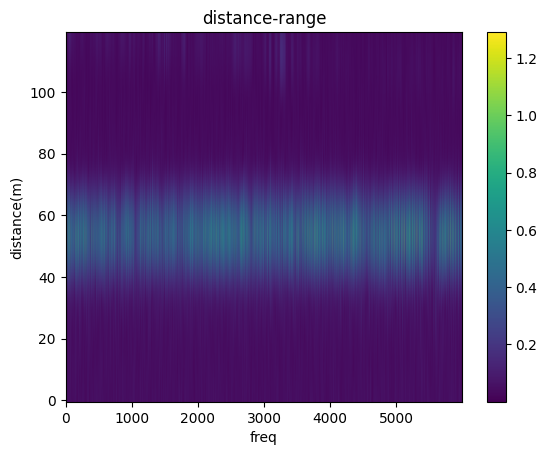

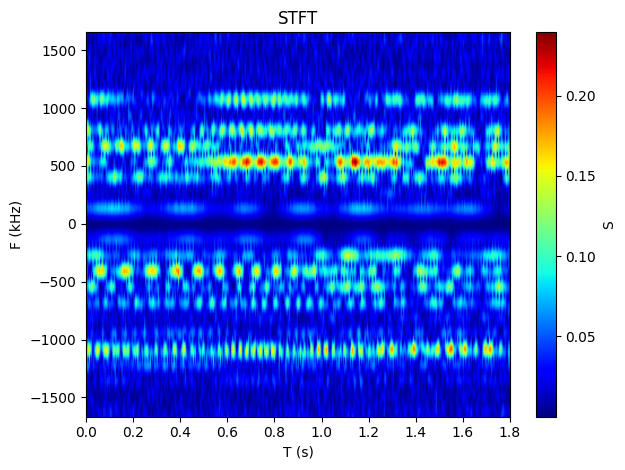

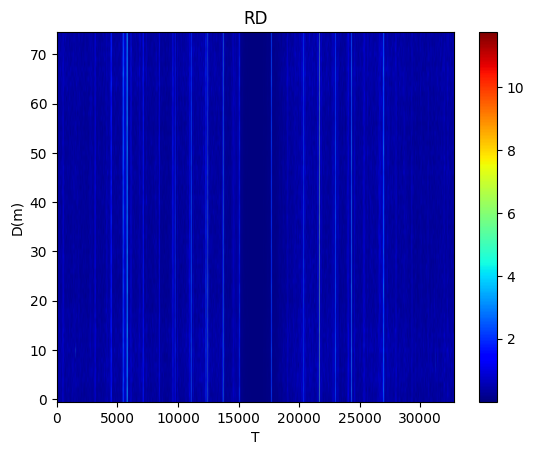

In [21]:
# vis distance-frequency
plt.figure()
plt.imshow(echo_FFT, aspect='auto')
plt.xlabel(r"freq")
plt.ylabel(r"distance(m)")
plt.title(r"distance-range")
plt.gca().invert_yaxis()
plt.colorbar()


# vis STFT time-freq map
plt.figure()
plt.pcolormesh(STFT_t, STFT_f, STFT_Zxx, shading='gouraud', cmap='jet')
plt.title(f"STFT")
plt.ylabel("F (kHz)")
# plt.ylim([-PRF/2, PRF/2])
plt.xlabel("T (s)")
plt.colorbar(label='S')
plt.tight_layout()


# vis RD range-Doppler map
plt.figure()
plt.imshow(echo_RD, aspect='auto', cmap='jet')
plt.xlabel(r"T")
plt.ylabel(r"D(m)")
plt.title(r"RD")
plt.gca().invert_yaxis()
plt.colorbar()


In [22]:
model = JointMultimodalTransformer().cuda() # 将模型移到GPU

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 前向传播
output = model(echo_FFT, echo_RD)

# 计算损失
loss = criterion(output)

# 反向传播和优化
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(output)

C:\Users\47391\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


AssertionError: Torch not compiled with CUDA enabled